In [1]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np
from matplotlib.patches import Rectangle

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.map_expansion import arcline_path_utils
import math
from typing import Tuple

from example.dataset.utils import create_rotated_rectangle
import matplotlib.pyplot as plt

In [2]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-trainval...


: 

In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'}
df = pd.read_csv(DATAROOT / 'train_v1.0-mini_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city ='singapore-onenorth'#'singapore-hollandvillage' # 'boston-seaport' #'boston-seaport'#
df = df[df['location'] == city]
df.head()

,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,acceleration,yaw_rate,delta_local_x,delta_local_y
163,cc8c0bf57f984915a77078b10eb33198,0.047124,singapore-onenorth,lidar,2018-07-24 03:28:47.647951,"[0.5720320396729045, -0.0016977771610471074, 0...",411.303935,1180.890379,0.0,-1.923645,8.988266,NaN,0.011631,0.000000,0.000000
164,cc8c0bf57f984915a77078b10eb33198,0.054105,singapore-onenorth,lidar,2018-07-24 03:28:48.147847,"[0.5744205119534879, -0.0013288675751650467, 0...",409.743152,1176.676973,0.0,-1.917831,8.988266,NaN,0.011631,0.008588,4.493190
165,cc8c0bf57f984915a77078b10eb33198,0.062832,singapore-onenorth,lidar,2018-07-24 03:28:48.698048,"[0.5769635824169542, -0.002992466963982372, 0....",408.101879,1172.151578,0.0,-1.911575,8.749225,-0.434462,0.011372,0.004292,4.813830
166,cc8c0bf57f984915a77078b10eb33198,0.061087,singapore-onenorth,lidar,2018-07-24 03:28:49.197353,"[0.5816882559843612, 0.0007711656267377917, 0....",406.726006,1168.211287,0.0,-1.900030,8.358815,-0.781906,0.023122,-0.020173,4.173550
167,cc8c0bf57f984915a77078b10eb33198,0.062832,singapore-onenorth,lidar,2018-07-24 03:28:49.697797,"[0.5835988412073946, -0.00036295026906284396, ...",405.409406,1164.354227,0.0,-1.895311,8.143926,-0.429398,0.009428,-0.001170,4.075579


In [4]:
env = SelfDrivingEnvironment(city)
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)
#nusc_exp = NuScenesMapExplorer(nusc_map)

Render

In [5]:
scene_test = df['scene_token'].unique()[0] #'295c6c85275e4376bc8446b4a76504cd'#
example_scene_df = df[df['scene_token']==scene_test]
#ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=[scene_test], verbose=False)


In [6]:
#nuscenes.render_scene(scene_test)

Test progress discretization

SCENE cc8c0bf57f984915a77078b10eb33198
[-0.40886684 -0.89108403]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[-0.40234778 -0.89404648]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
(<BlockProgress.START: 1>, <LanePosition.CENTER: 2>)
(<BlockProgress.START: 1>, <LanePosition.CENTER: 2>)
(<BlockProgress.START: 1>, <LanePosition.CENTER: 2>)
(<BlockProgress.MIDDLE: 2>, <LanePosition.CENTER: 2>)
(<BlockProgress.MIDDLE: 2>, <LanePosition.CENTER: 2>)
[-0.3426186  -0.93481711]
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
[-0.3426186  -0.93481711]
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
[-0.3426186  -0.93481711]
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
[-0.31782825 -0.86717795]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[-0.31782825 -0.86717795]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[-0.32207329 -0.92902904]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[-0.22239159 -0.95779337]
(<BlockProgress.START:

/home/saramontese/.local/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1012: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


[ 0.50550445 -0.80494848]
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
[ 0.50550445 -0.80494848]
(<BlockProgress.END: 3>, <LanePosition.RIGHT: 3>)
[ 0.72019825 -0.67993218]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[ 0.79204822 -0.59468724]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[ 0.85386299 -0.50190766]
(<BlockProgress.INTERSECTION: 4>, <LanePosition.RIGHT: 3>)
[ 0.91942836 -0.39283161]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942836 -0.39283161]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942836 -0.39283161]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942836 -0.39283161]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942853 -0.39283122]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942853 -0.39283122]
(<BlockProgress.START: 1>, <LanePosition.RIGHT: 3>)
[ 0.91942853 -0.39283122]
(<BlockProgress.MIDDLE: 2>, <LanePosition.RIGHT: 3>)
[ 0.91942853 -0.39283122]
(<BlockProgress.MIDD

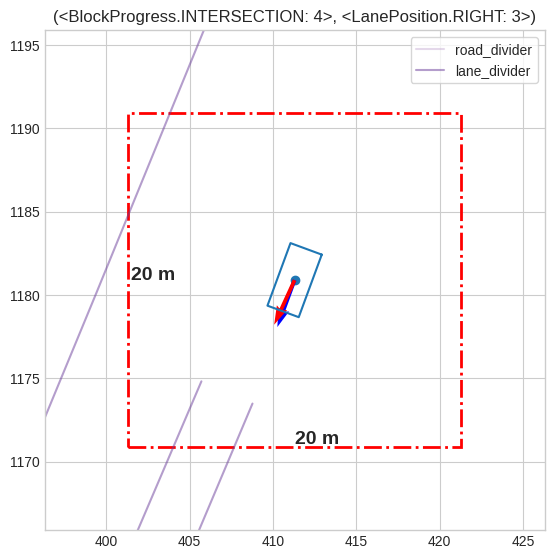

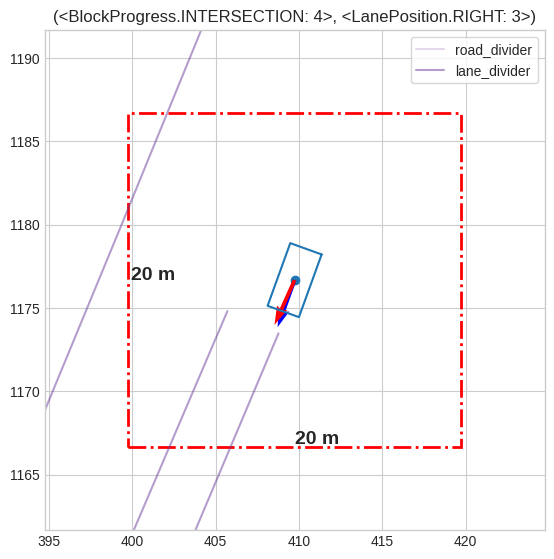

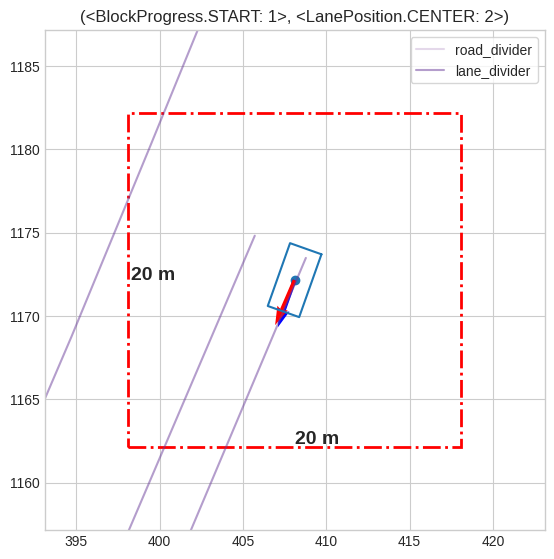

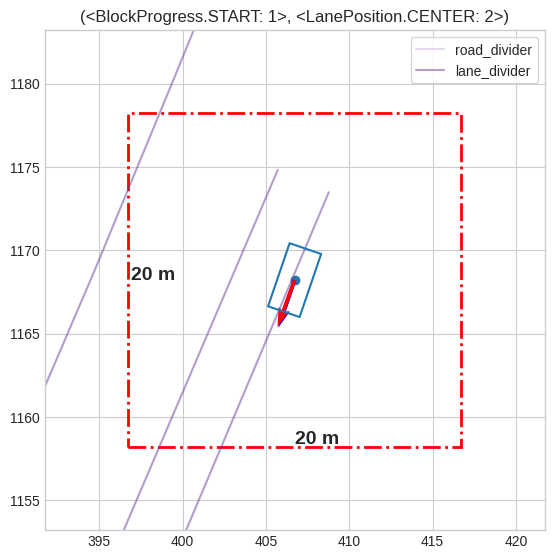

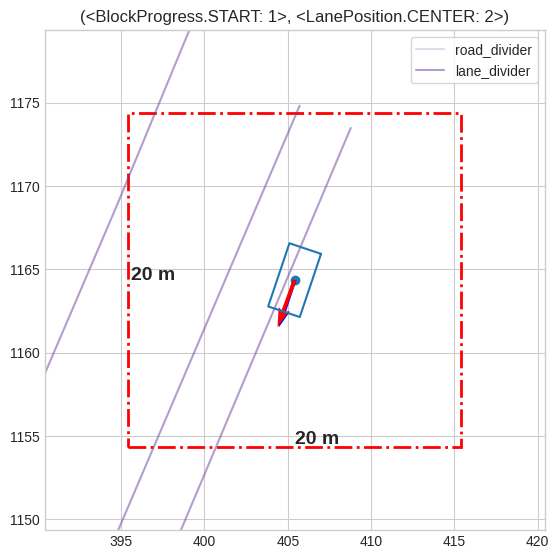

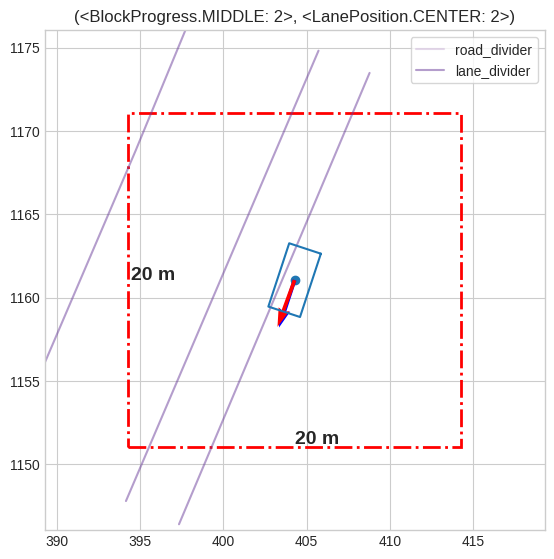

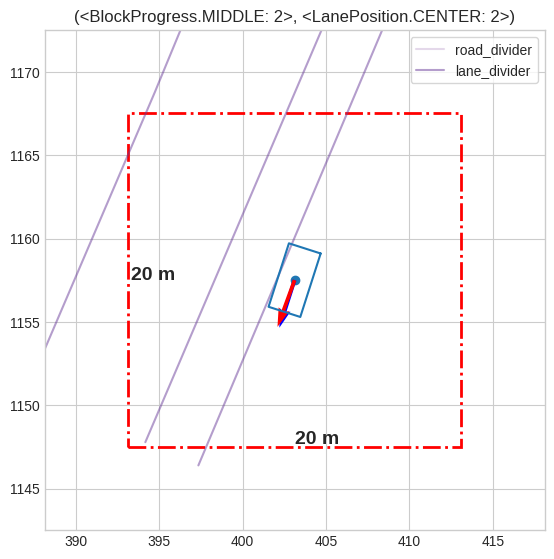

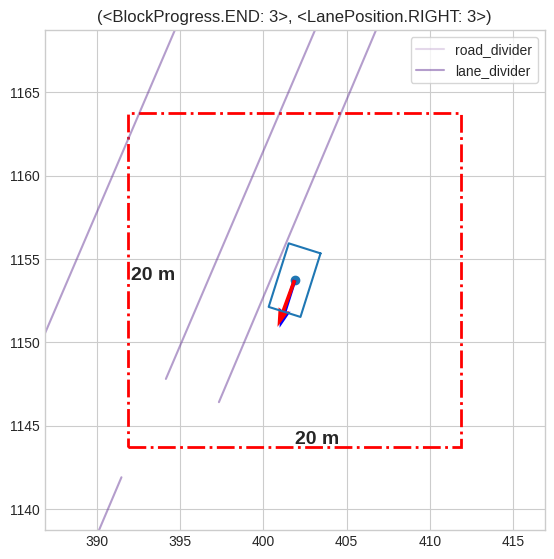

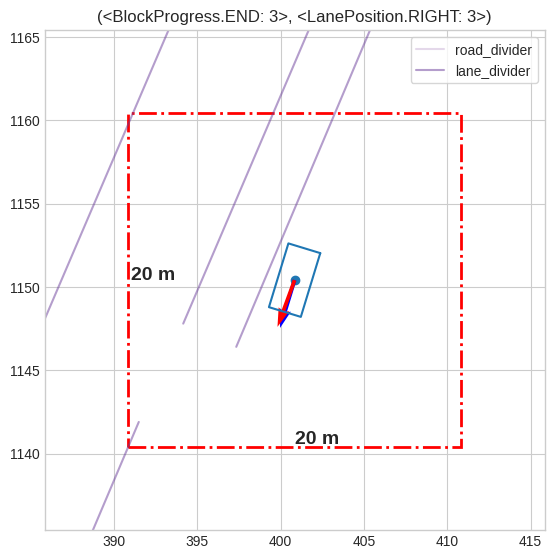

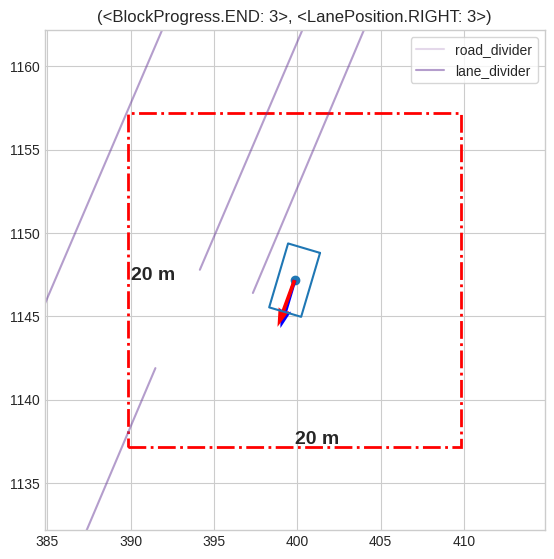

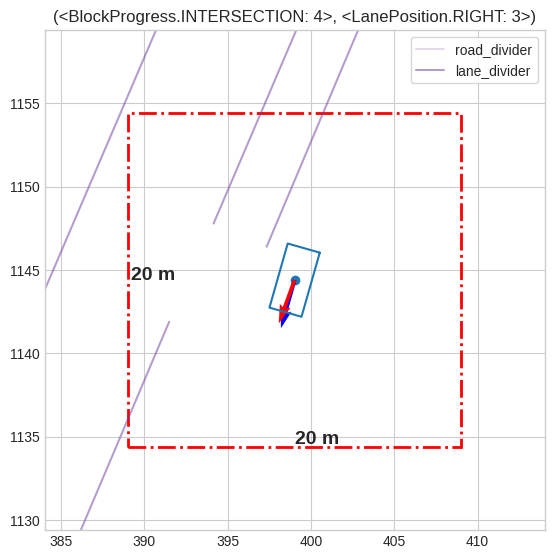

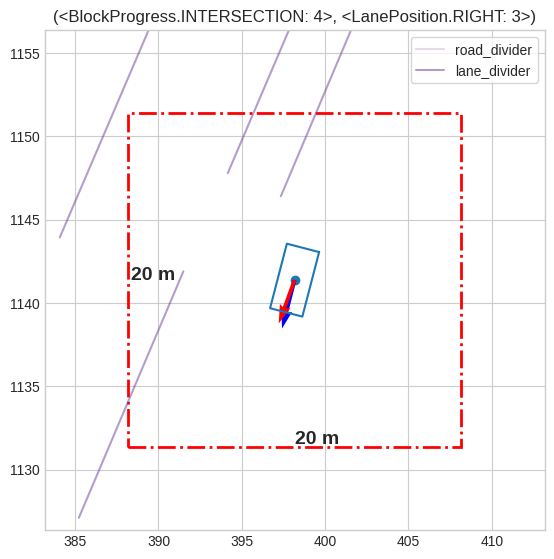

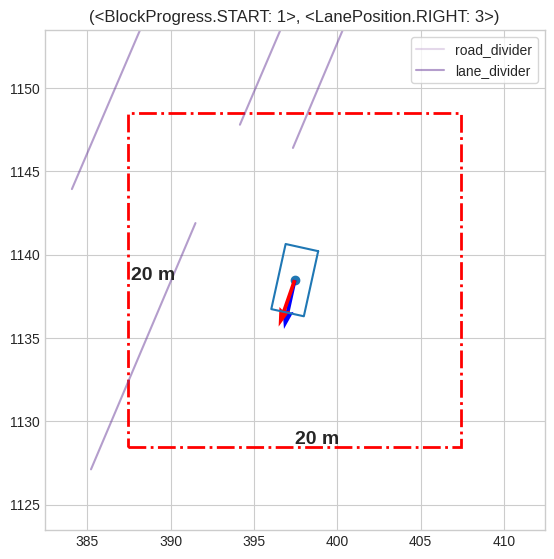

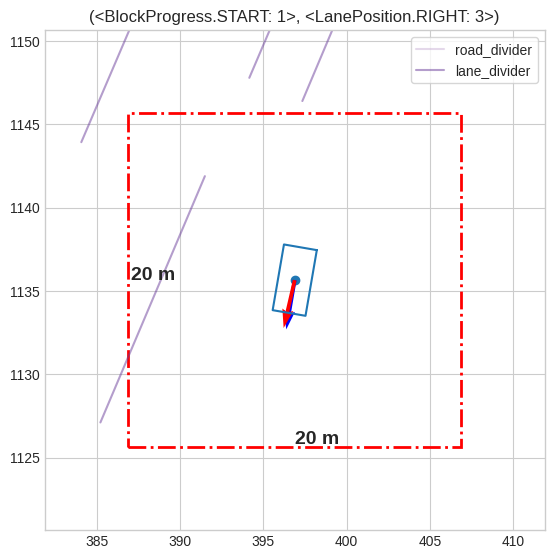

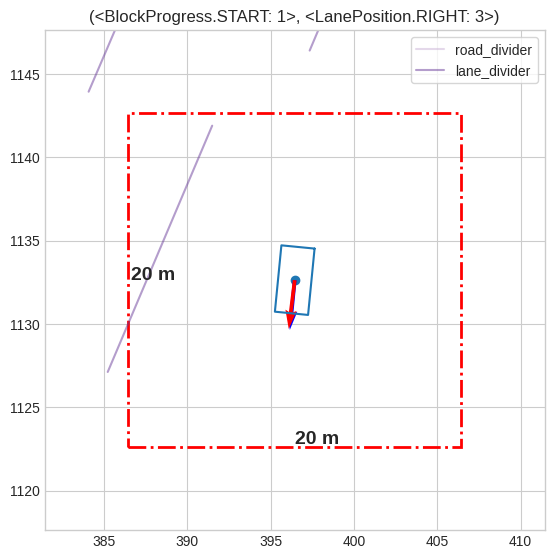

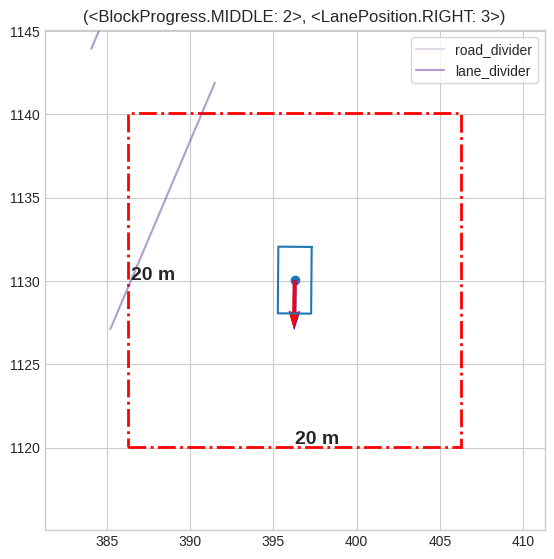

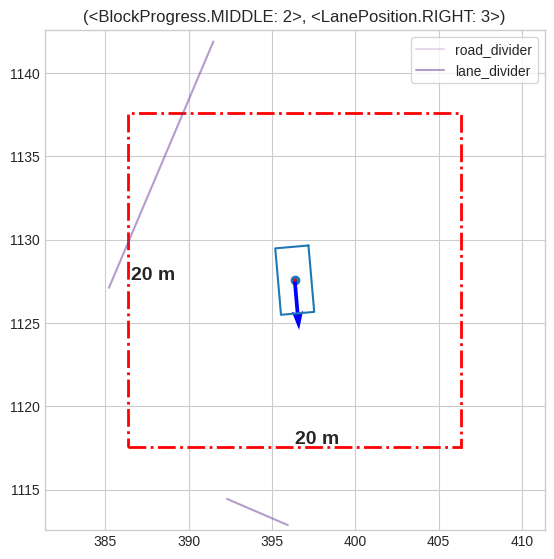

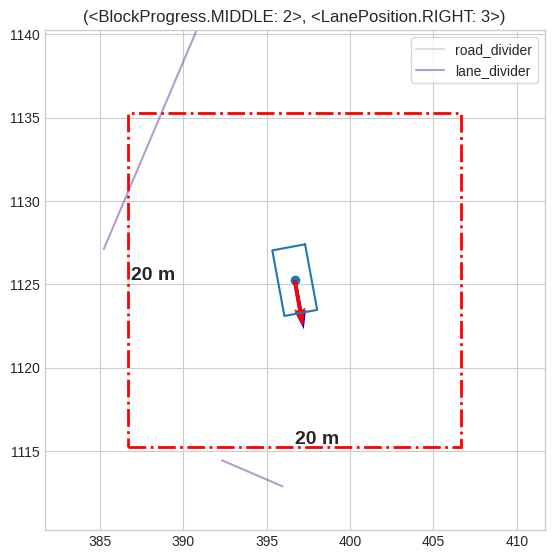

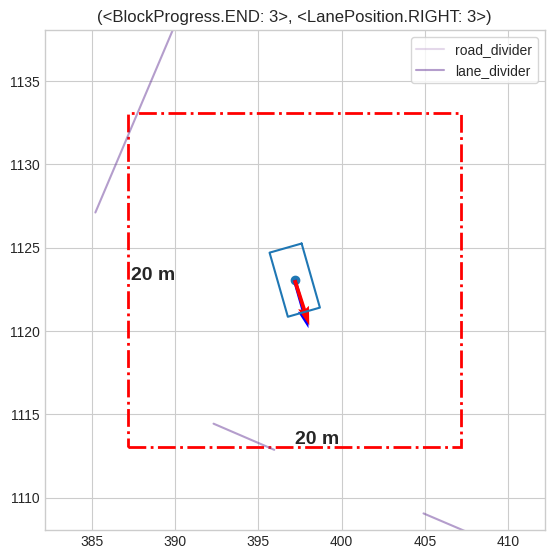

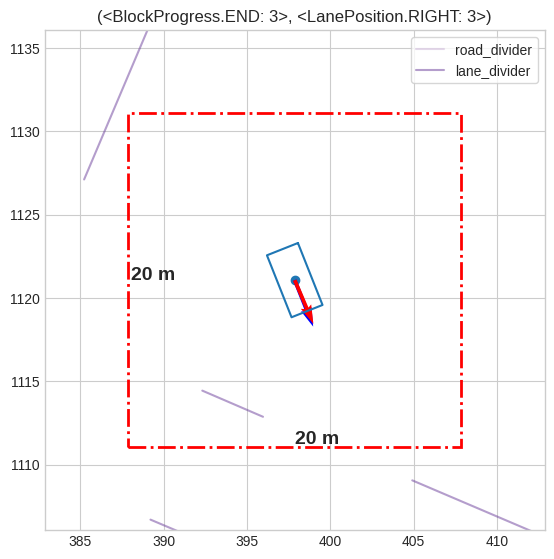

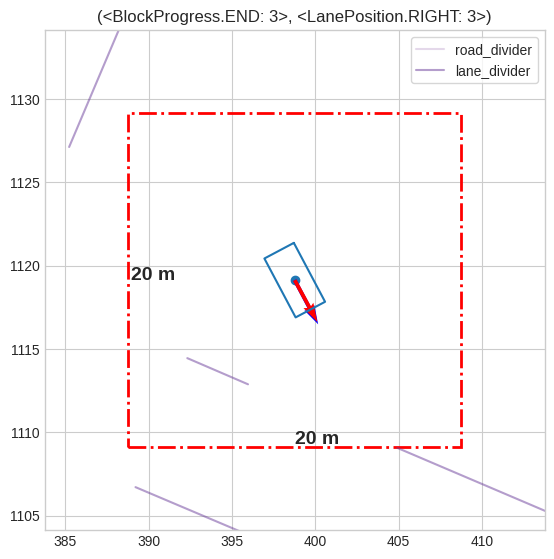

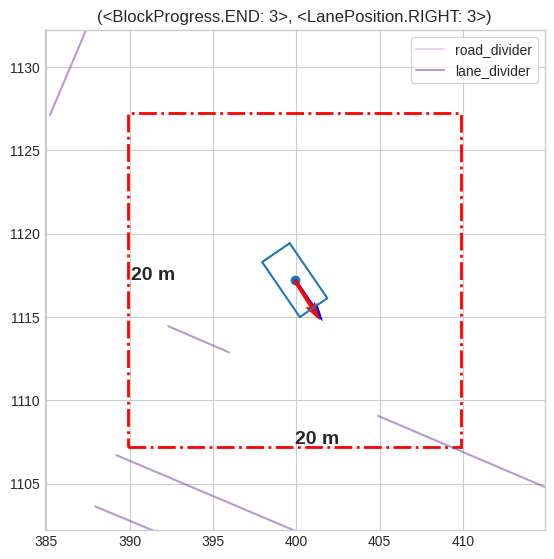

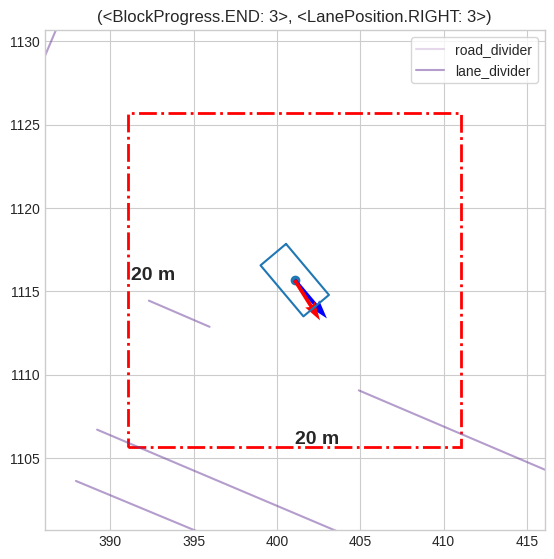

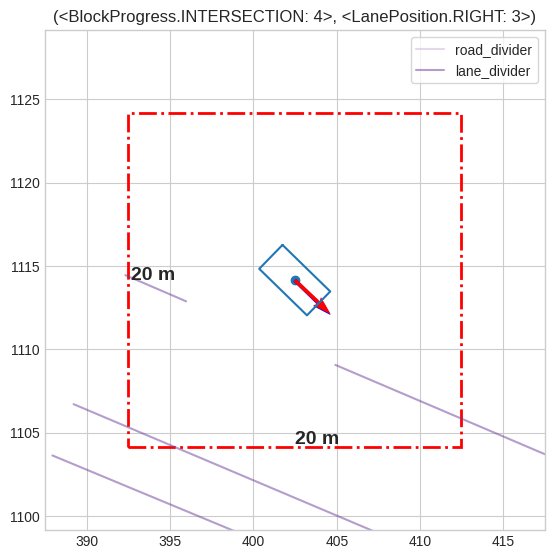

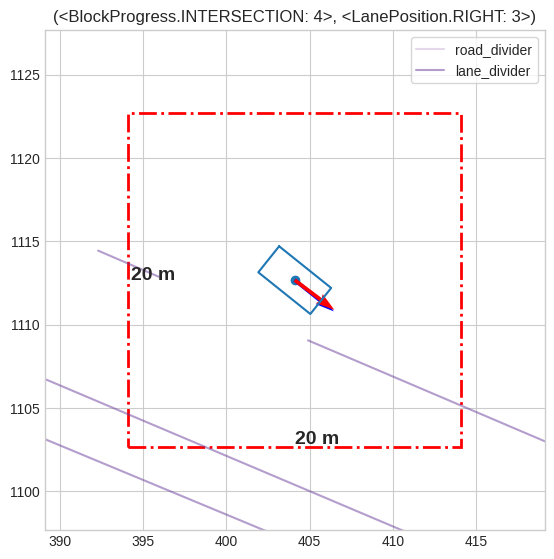

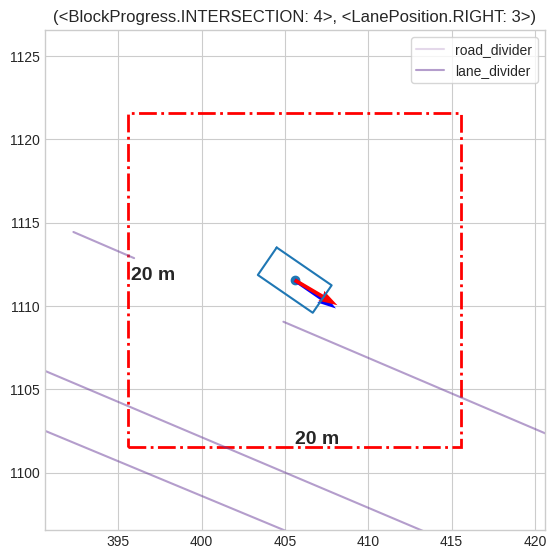

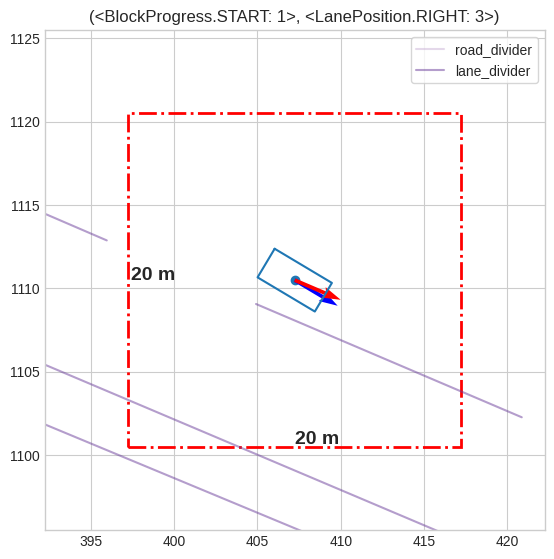

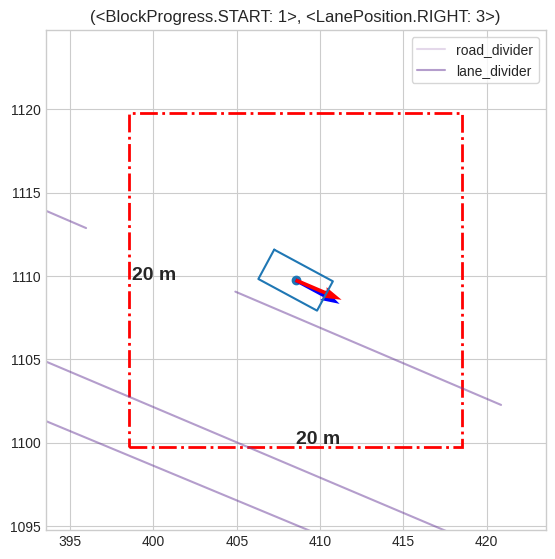

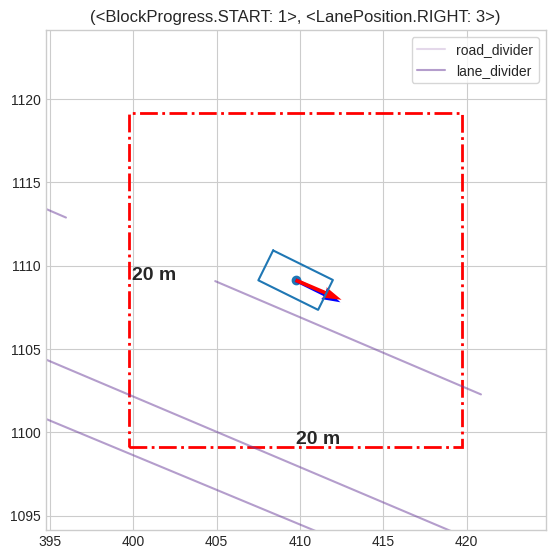

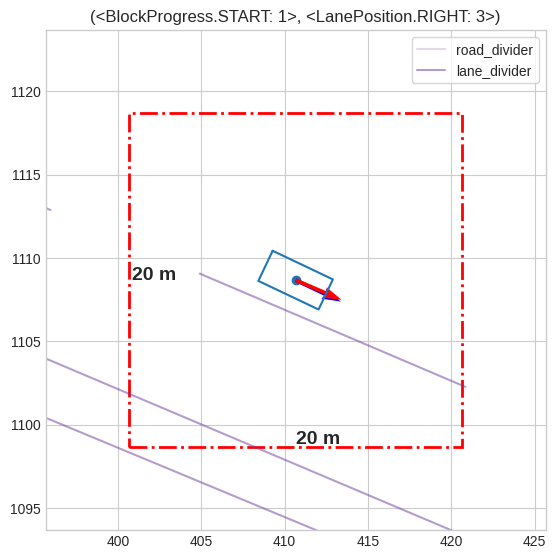

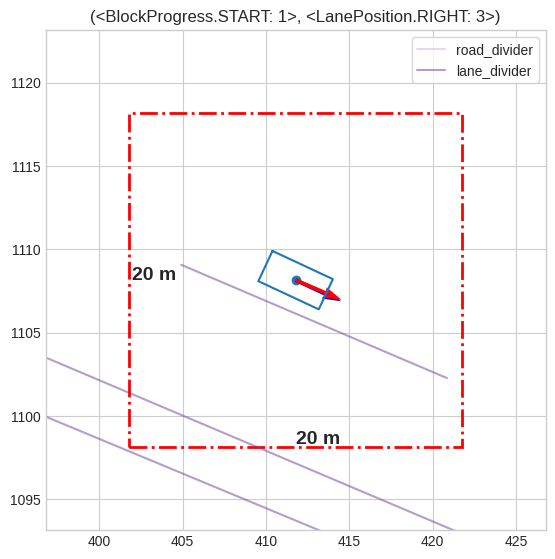

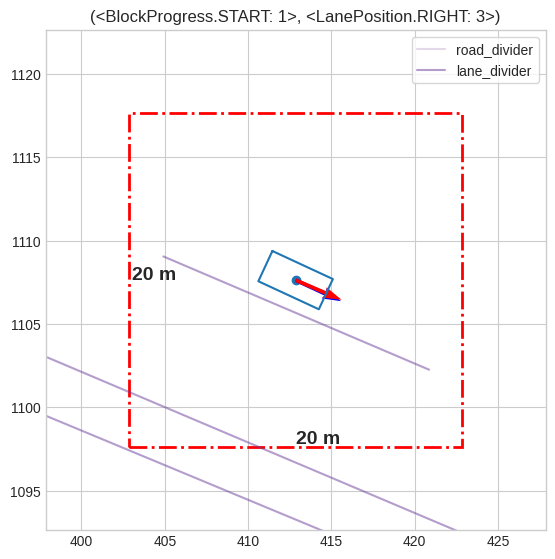

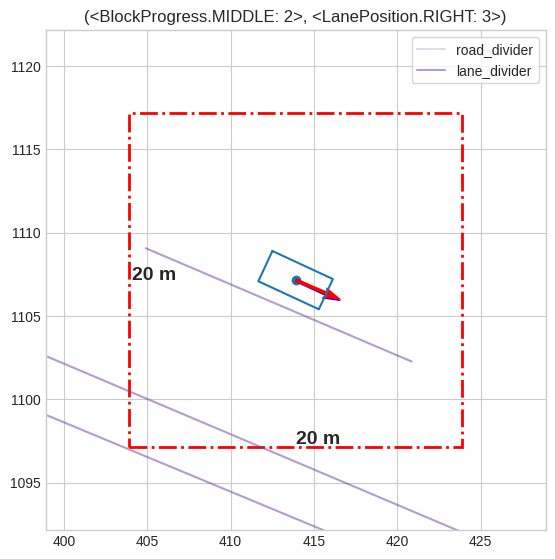

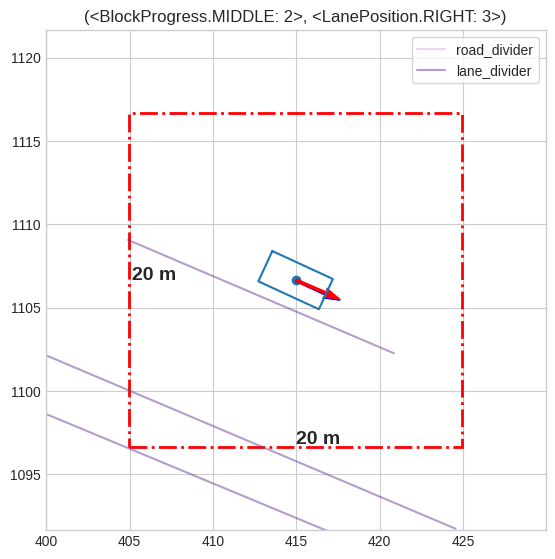

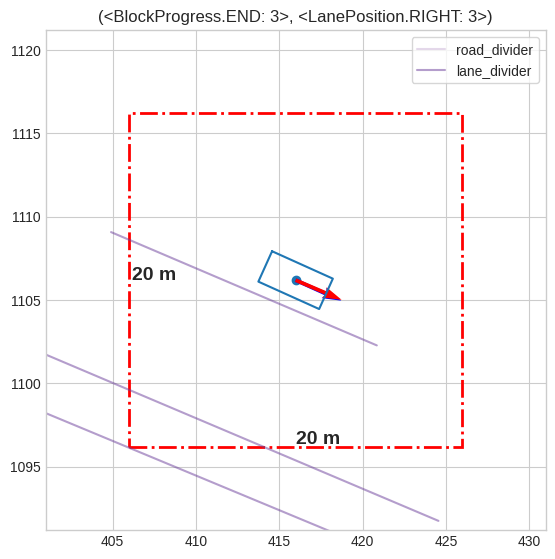

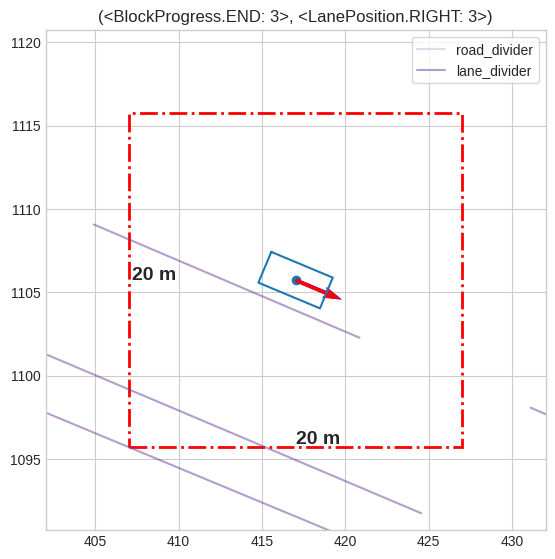

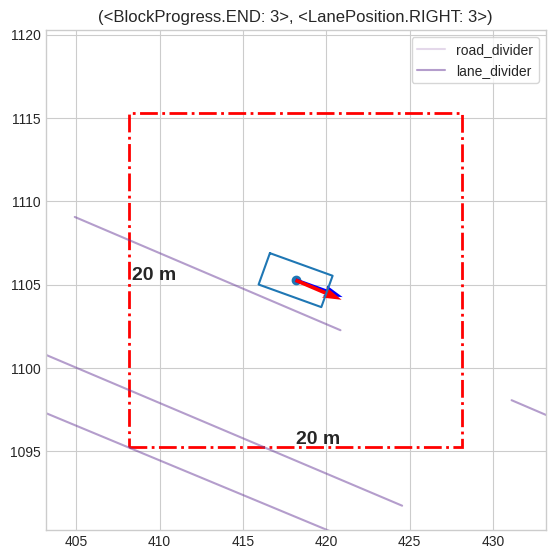

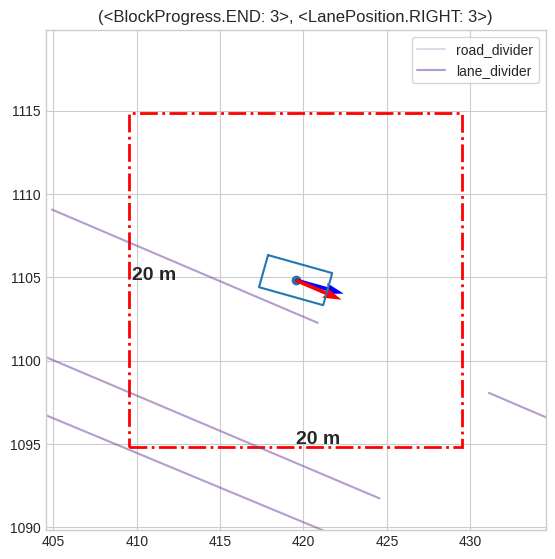

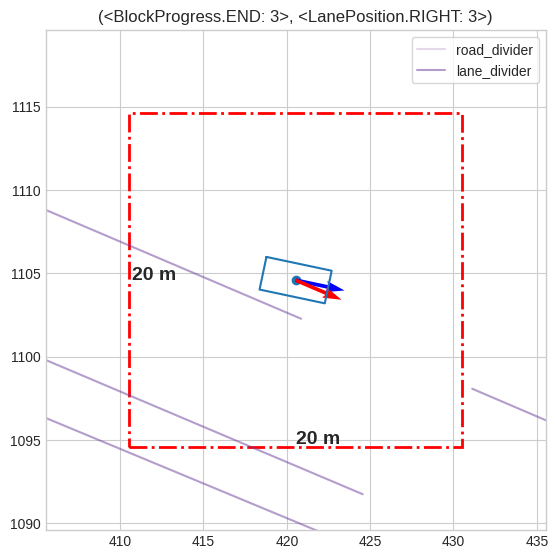

In [7]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']==scene]
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        
        x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
        
        lane_predicates = env.get_lane_info(x,y, yaw, eps=0.3, agent_size=(2,4))
        print(lane_predicates)
        if False:########
            #PLOT
            ########
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            current_lane = nusc_map.record_on_point(x,y, 'lane')

            if road_segment_token and nusc_map.get('road_segment', road_segment_token)['is_intersection'] and not current_lane:
                closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
                lane_path = nusc_map.get_arcline_path(closest_lane)
                closest_pose_idx_to_lane, lane_record, _ = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane_path)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                    tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

            else:

                lane = nusc_map.get_arcline_path(current_lane)
                closest_pose_idx_to_lane, lane_record, distance_along_lane = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                        tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

    
              
            patch_size = 20
            patch_box = [x,y, patch_size, patch_size]
            patch = NuScenesMapExplorer.get_patch_coord(patch_box)
            minx, miny, maxx, maxy = patch.bounds

            fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
            
            #ax.add_patch(Rectangle((x, y), agent_size[0], agent_size[1], yaw))
            ax.scatter(x,y)
            heading_vector = np.array([np.cos(yaw), np.sin(yaw)])

            yaw =  math.degrees(-(math.pi / 2) + yaw)
            rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
            ax.quiver(x, y, heading_vector[0], heading_vector[1], color='b', scale=10, label='Ego Direction')
            ax.quiver(x,y, tangent_vector[0], tangent_vector[1],  color='r', scale=10, label='Lane Direction')
            x,y = rotated_rectangle.exterior.xy
            ax.plot(x,y)
            ax.set_title(lane_predicates)
            
    print('-------------------------')

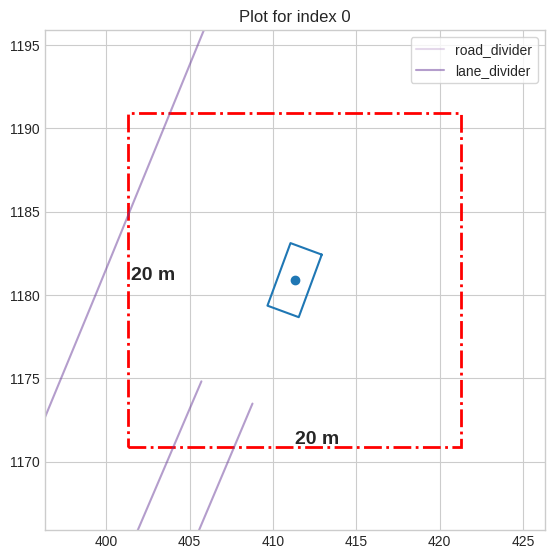

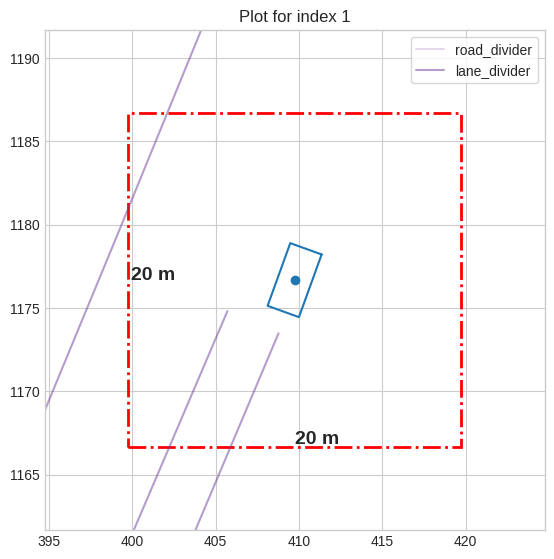

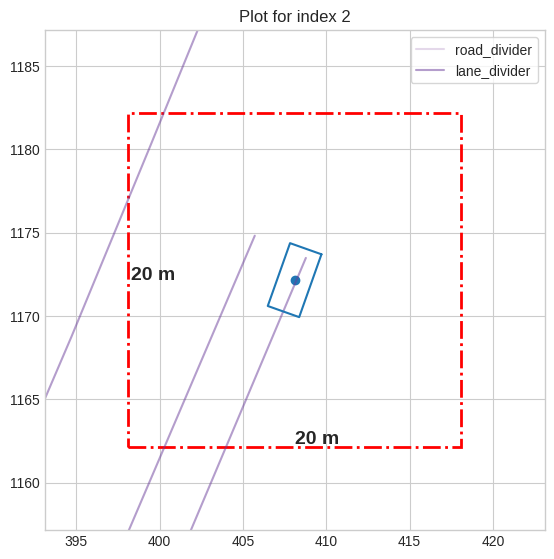

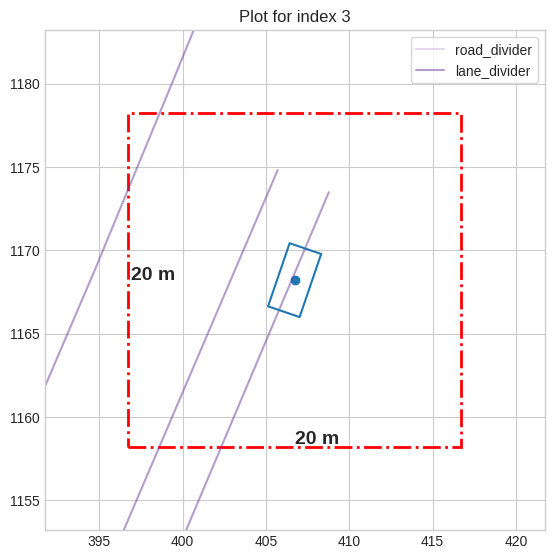

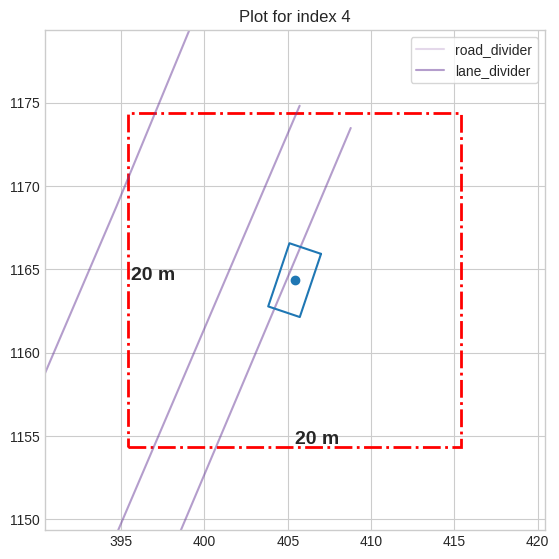

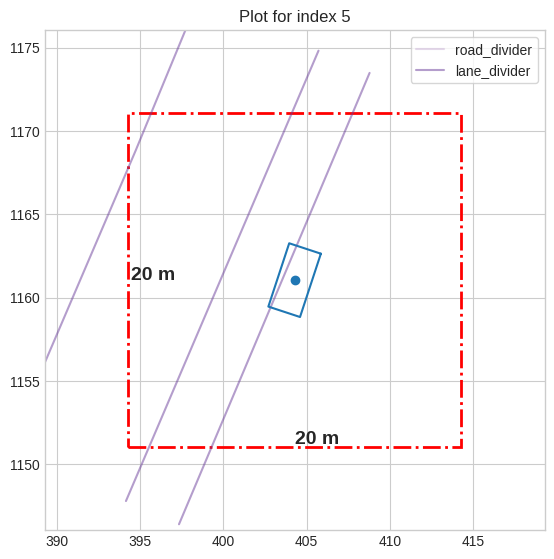

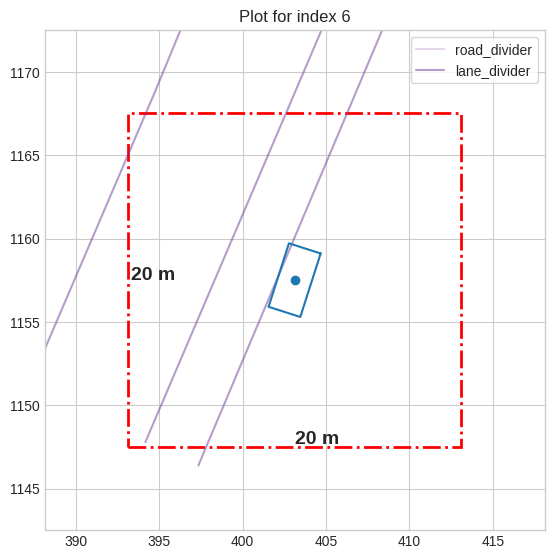

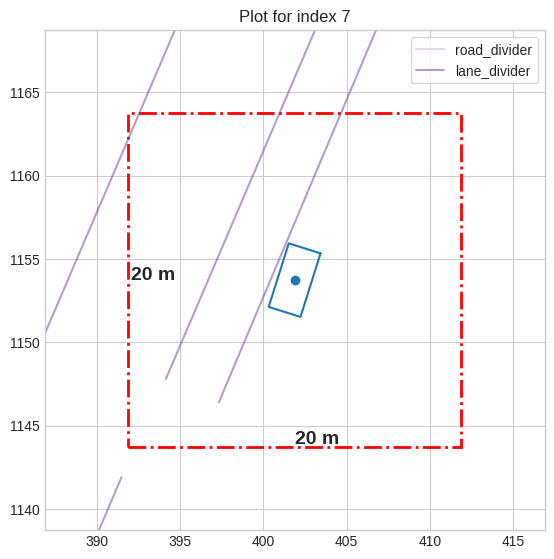

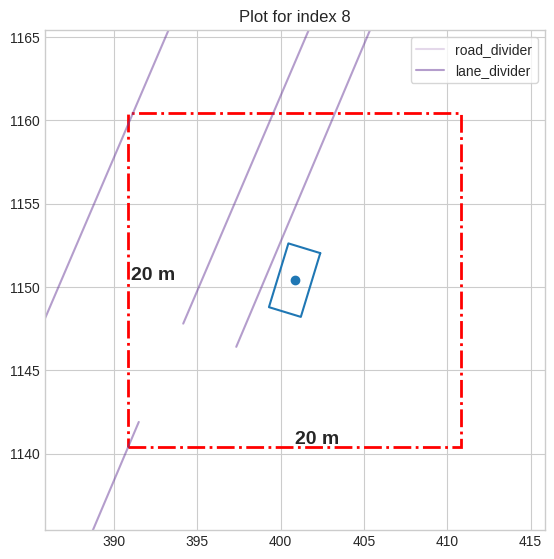

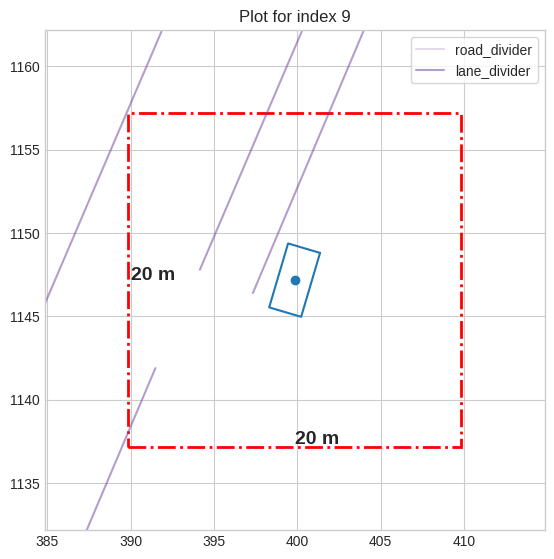

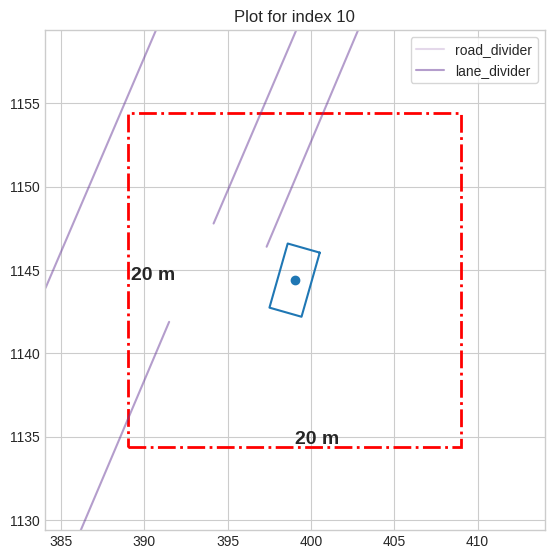

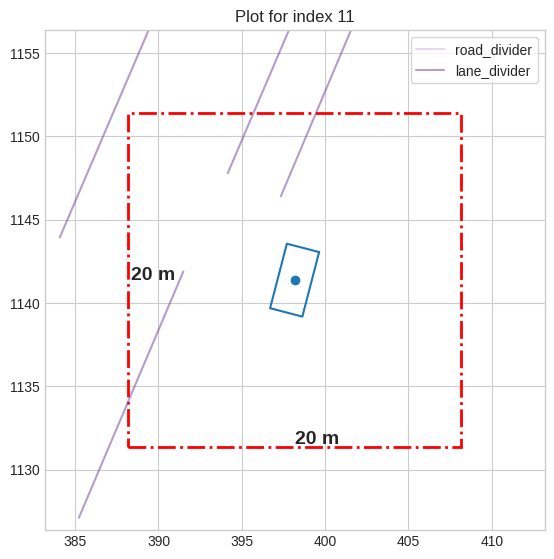

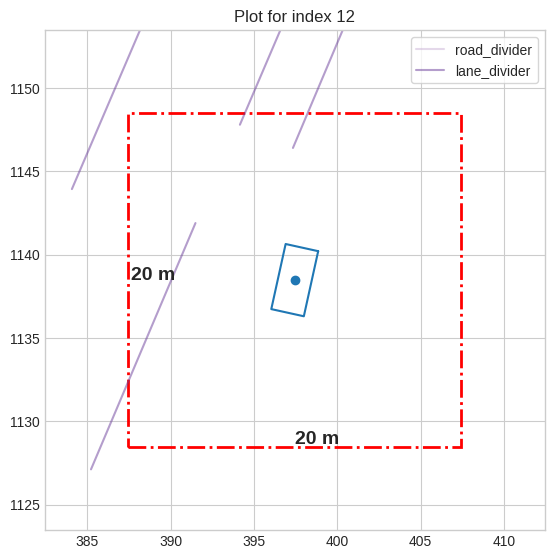

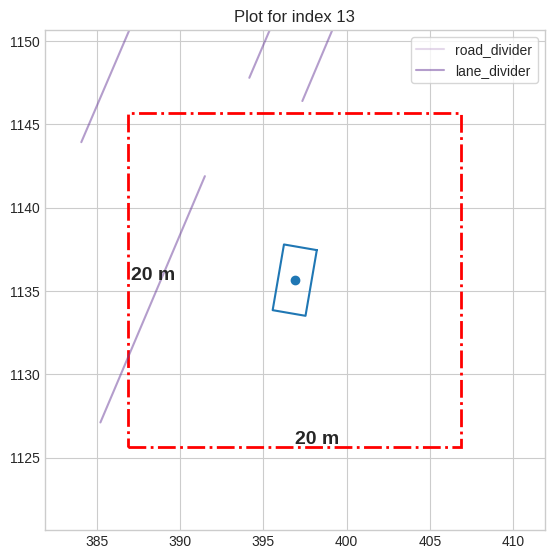

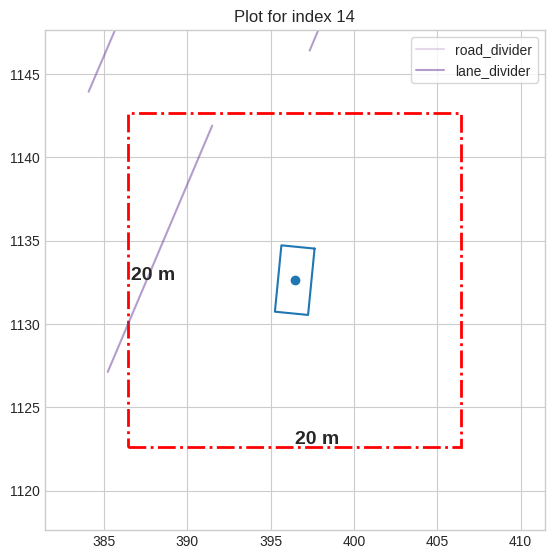

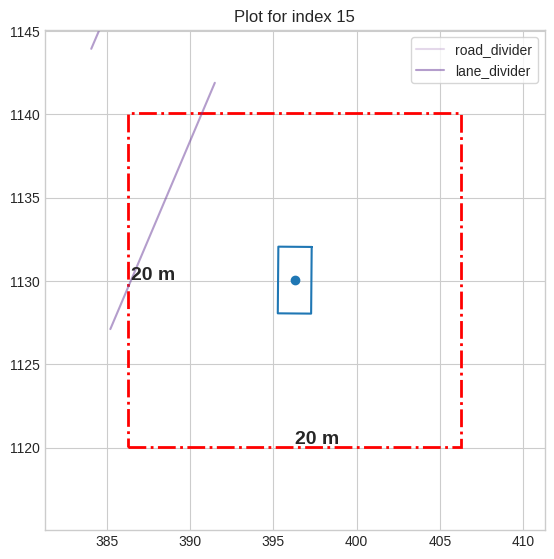

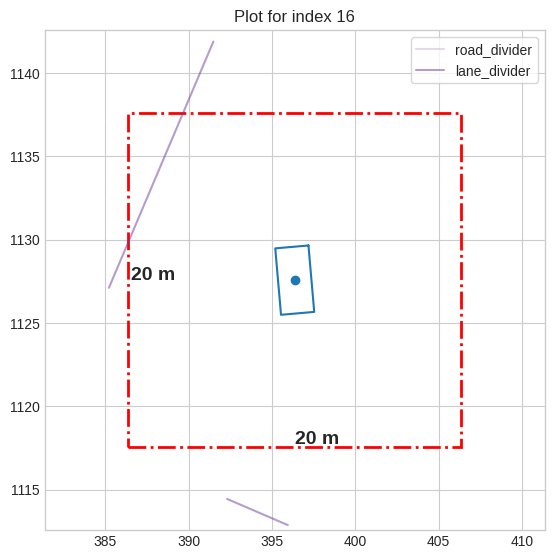

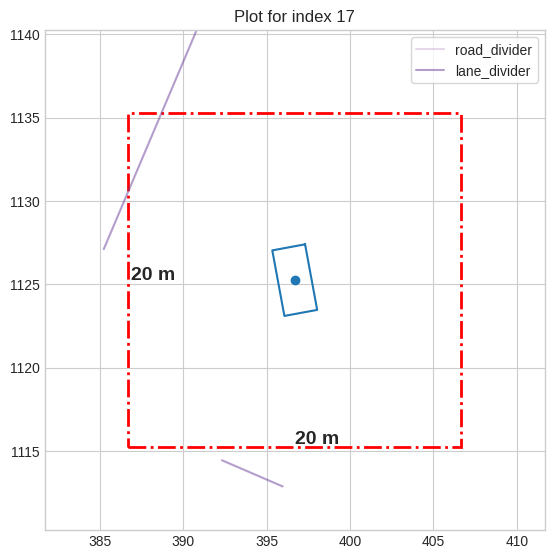

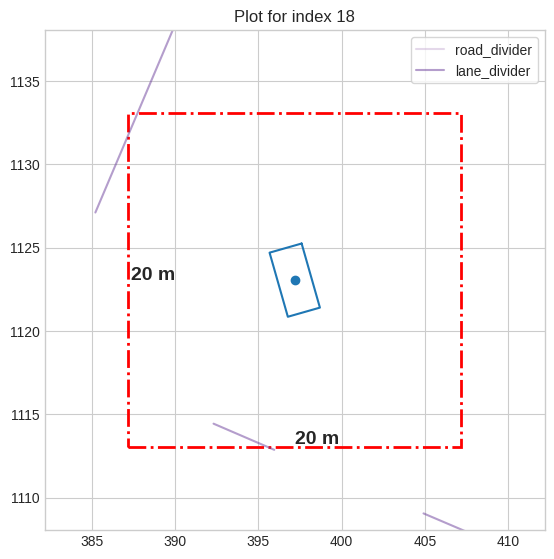

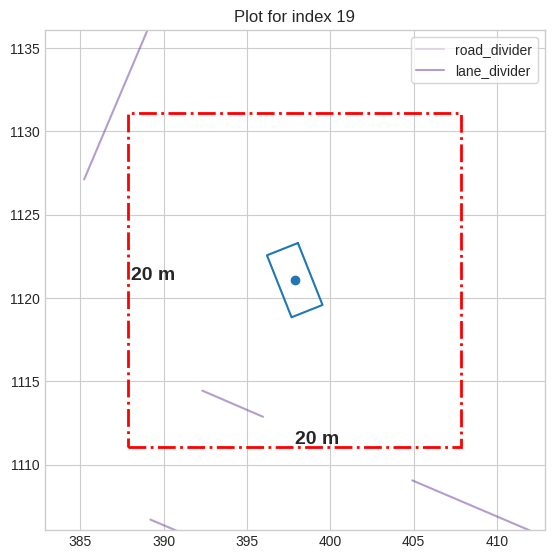

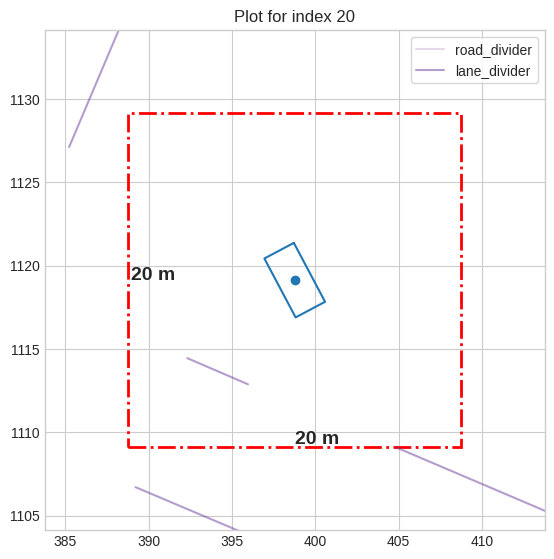

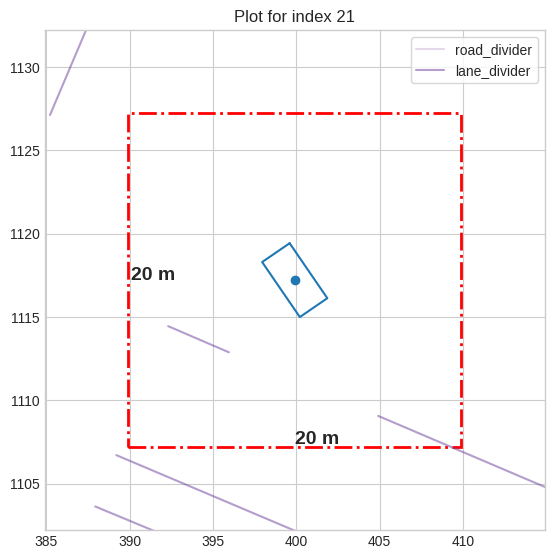

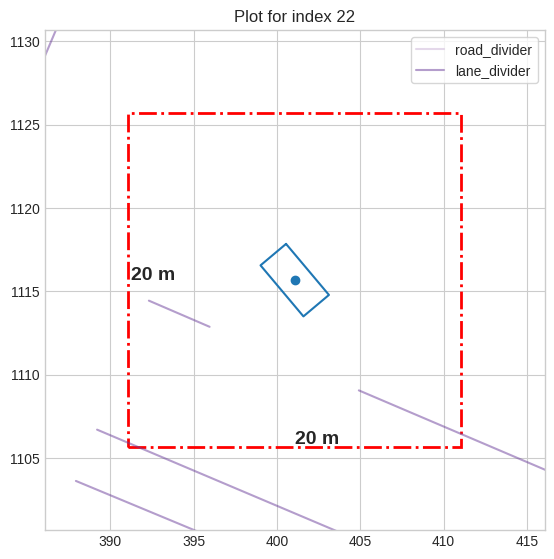

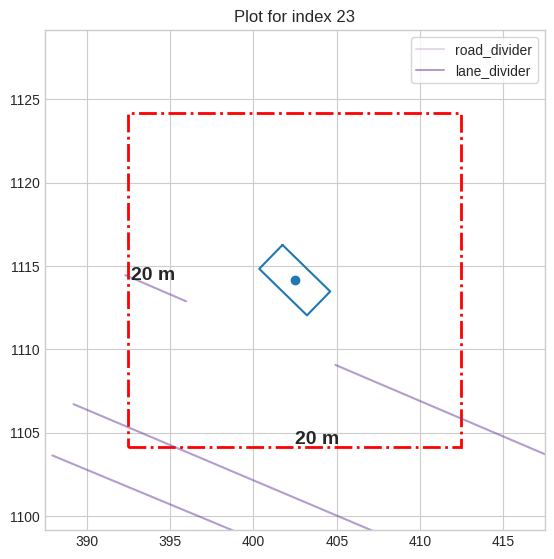

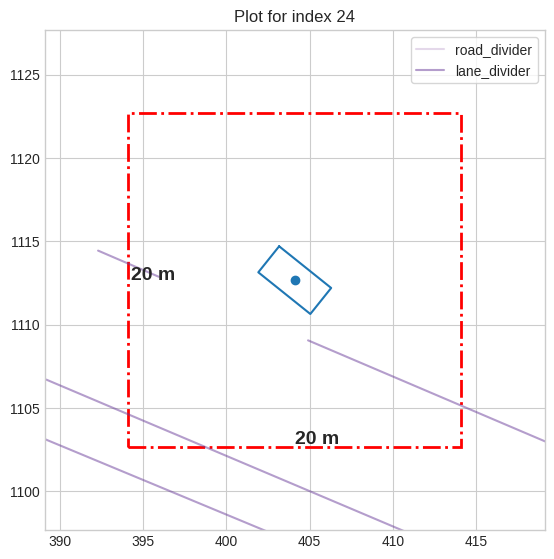

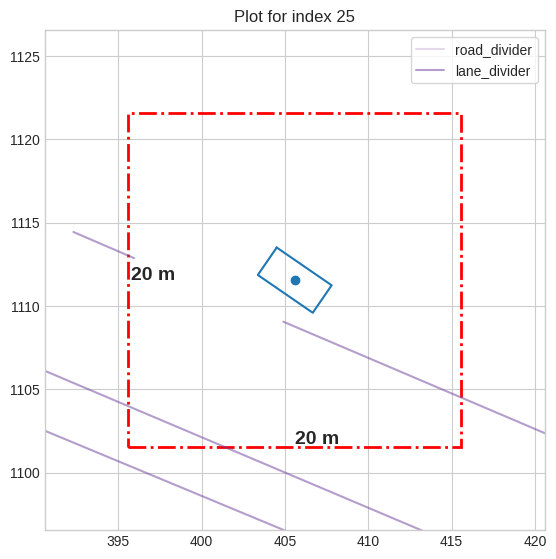

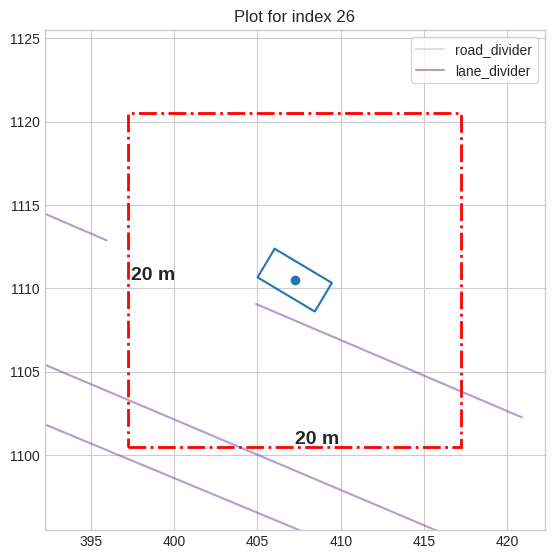

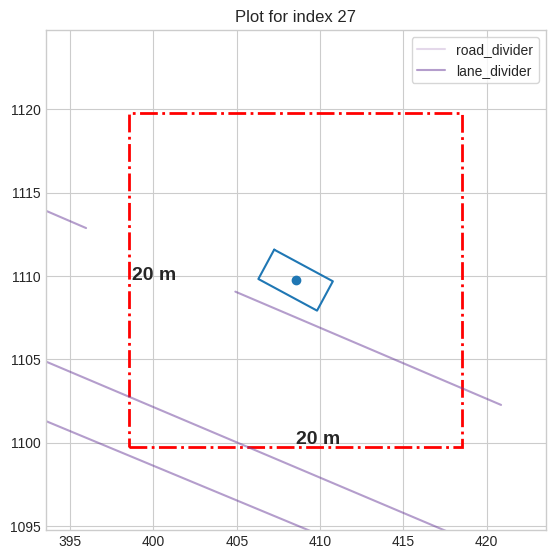

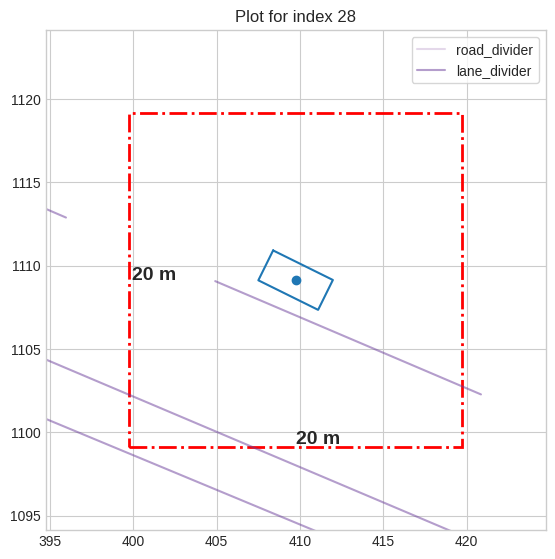

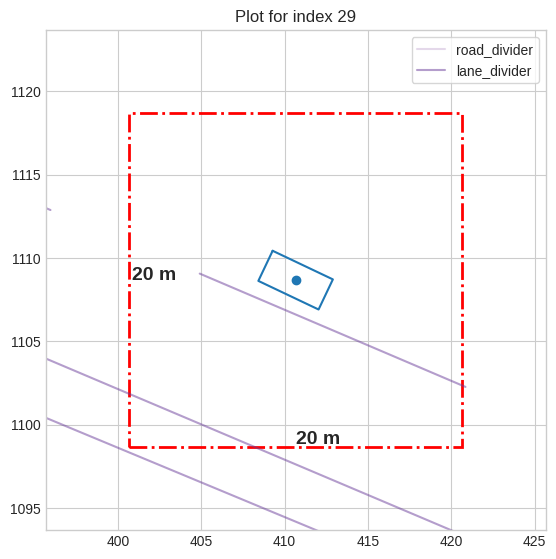

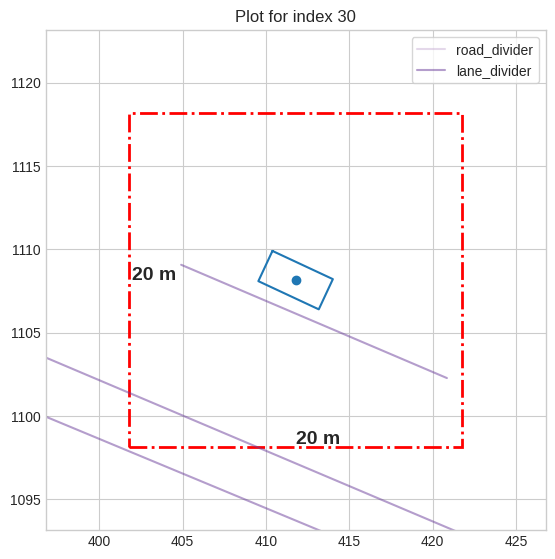

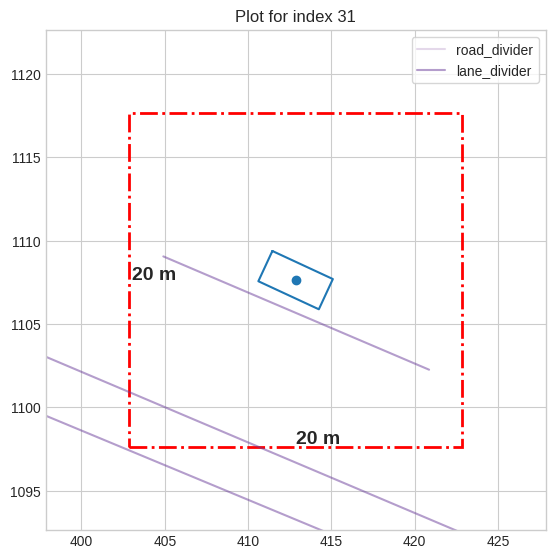

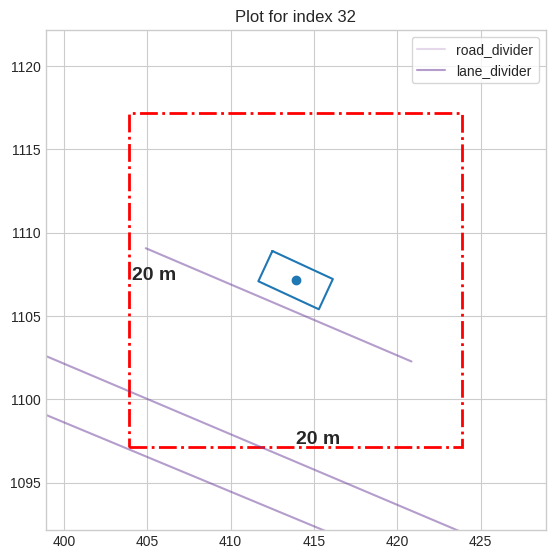

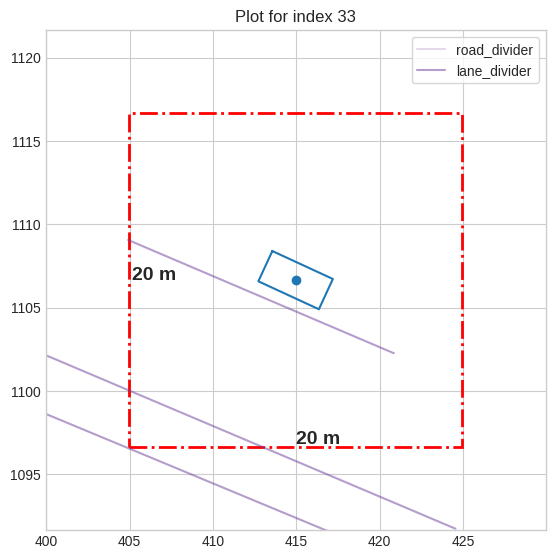

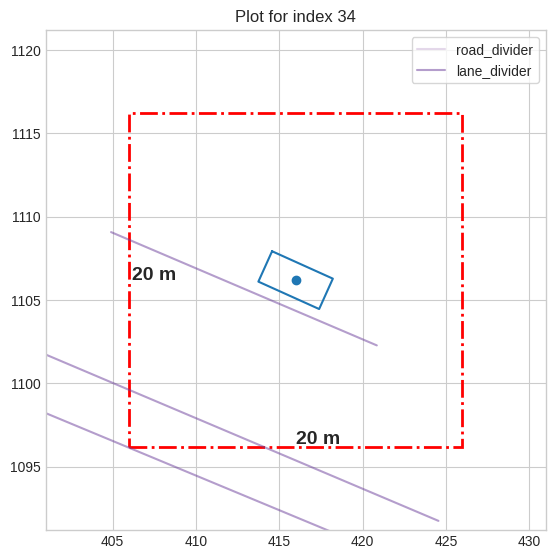

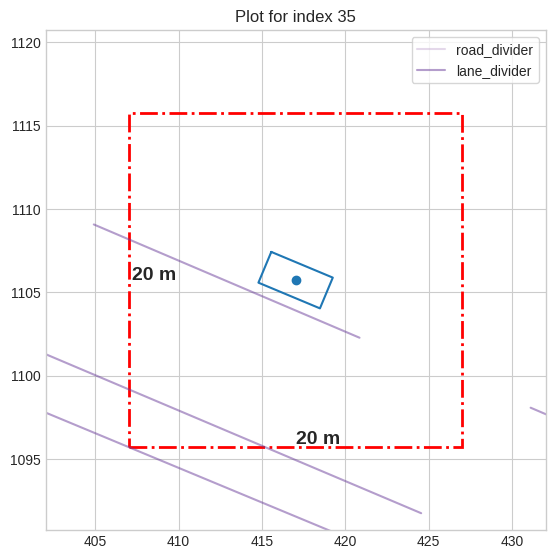

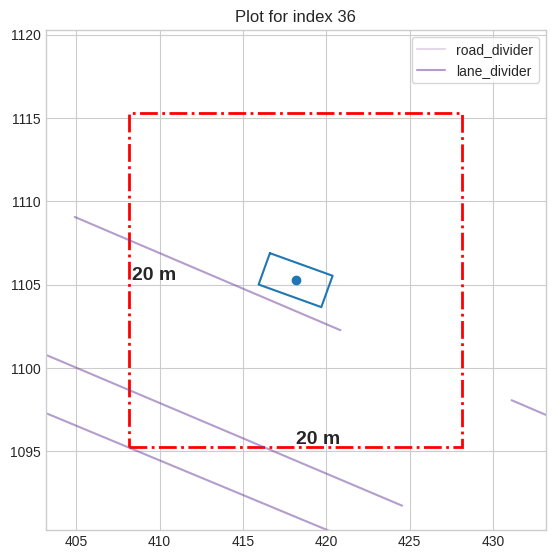

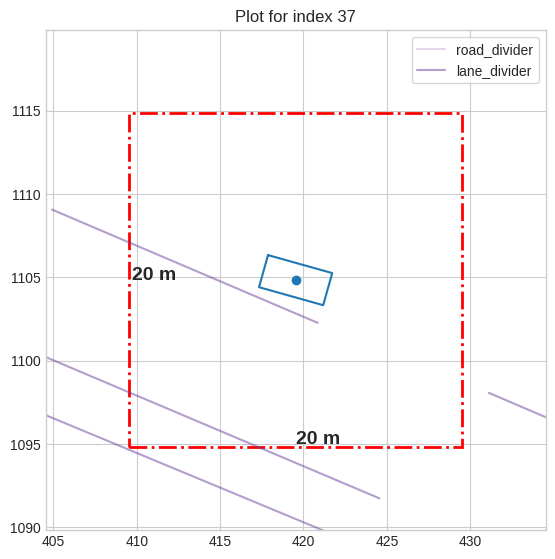

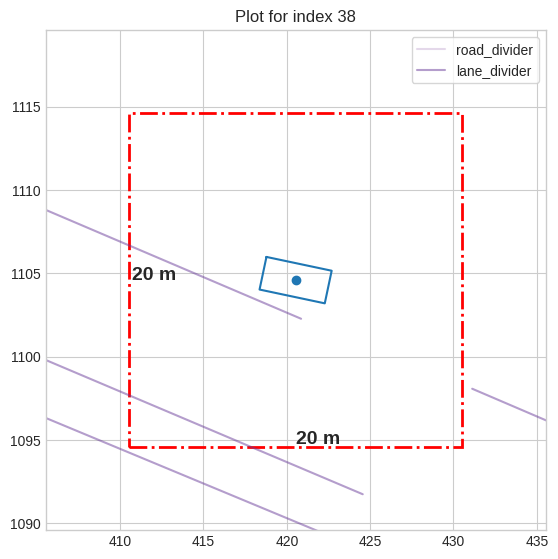

In [8]:

for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    yaw =  math.degrees(-(math.pi / 2) + yaw)
    if True:#is_on_divider(x,y,yaw, (2,4), ['road_divider', 'lane_divider']) in [True]:

         #for visual confirmation
        patch_size = 20
        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
        
        ax.scatter(x,y)

        rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y)
    
        plt.title(f'Plot for index {i}')
        plt.show()
